In [93]:
import Pkg
Pkg.activate(".")
Pkg.resolve()
Pkg.instantiate()
using DataFrames, CSV, Plots, Roots, DifferentialEquations, Optim, GLM

  Activating project at `~/Documents/Still evolving/estimu`
  No Changes to `~/Documents/Still evolving/estimu/Project.toml`
  No Changes to `~/Documents/Still evolving/estimu/Manifest.toml`
Precompiling project...
  ✓ Latexify → DataFramesExt
  ✓ DiffEqBase → DiffEqBaseUnitfulExt
  2 dependencies successfully precompiled in 6 seconds. 413 already precompiled.


## Estimated mutation rate increase is maximal for intermediate ciprofloxacin concentrations

In [94]:
MIC = 12
MAC = 8.5
df_Pribis = DataFrame(CSV.File("experimental_data/Pribis_Fig2D.txt"; comment="#"))

Row,cipro_concentration,number_experiments,no_cipro_mutation_rate,range_no,cipro_mutation_rate,range_cipro,fold_induction_mutation_rate,fold_min,fold_max,of_MIC
,Float64,Int64?,Float64,String15,Float64,String15,Float64,Float64,Float64,Float64
1,1.0,4,1.1,"(0.78,1.4)",1.7,"(1.2,2.2)",1.7,1.1,2.4,0.0833333
2,2.0,4,1.1,"(0.78,1.4)",2.3,"(2.0,2.6)",2.2,1.8,2.7,0.166667
3,4.0,4,1.1,"(0.78,1.4)",5.2,"(3.4,7.0)",4.8,4.2,5.3,0.333333
4,8.5,missing,0.62,"(0.51,0.75)",19.0,"(6,50)",30.0,11.0,67.0,0.708333
5,10.0,2,0.63,"(0.55,0.70)",10.0,"(10,11)",17.0,15.0,18.0,0.833333
6,12.0,9,1.2,"(0.92,1.4)",13.0,"(8.1,16)",11.0,7.1,15.0,1.0
7,14.0,2,0.63,"(0.55,0.70)",5.7,"(5.7,5.8)",9.3,8.3,10.0,1.16667


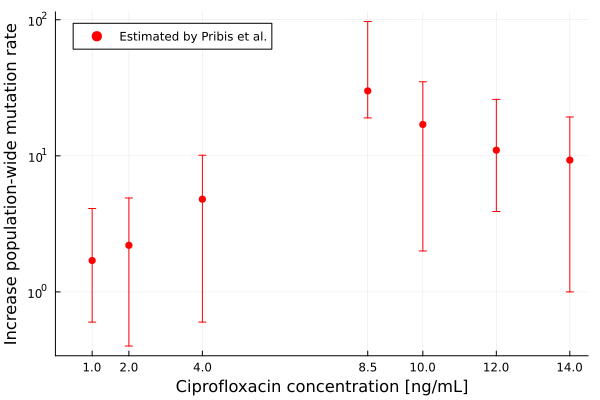

In [95]:
C = df_Pribis.cipro_concentration
M_MLE = df_Pribis.fold_induction_mutation_rate
M_lower = df_Pribis.fold_min
M_upper = df_Pribis.fold_max
P_M = plot(ylab="Increase population-wide mutation rate", xlab="Ciprofloxacin concentration [ng/mL]", yscale=:log10, legend=:topleft, xlim=(0,maximum(C)+0.5), xticks=([1,2,4,8.5,10,12,14]))
scatter!(C, M_MLE, yerror=(M_lower, M_upper), lab="Estimated by Pribis et al.", c=:red, markerstrokecolor=:red)

# Population dynamics with highly-mutating and slowly dividing subpopulation
## 1. Exponential growth

In [96]:
# Population growth dynamics of non-mutants (deterministic)
# Growth of response-off subpopulation: exponential growth with population growth rate = division-death-switching rate, initial population size N0
pop_size_exp(t, N0_off, pop_growth) = N0_off*exp(pop_growth*t)
# Growth of response-on subpopulation: influx from response-off subpopulation plus exponential growth with own net growth rate = division-death rate, initial population size N0_on 
function pop_size_exp(t, N0_off, pop_growth, switching, N0_on, net_growth_on)
    if net_growth_on == pop_growth
        return (N0_off*switching*t + N0_on) * exp(pop_growth*t)
    else
        return N0_off*switching/(pop_growth - net_growth_on) * (exp(pop_growth*t) - exp(net_growth_on*t)) + N0_on*exp(net_growth_on*t)
    end
end

pop_size_exp (generic function with 2 methods)

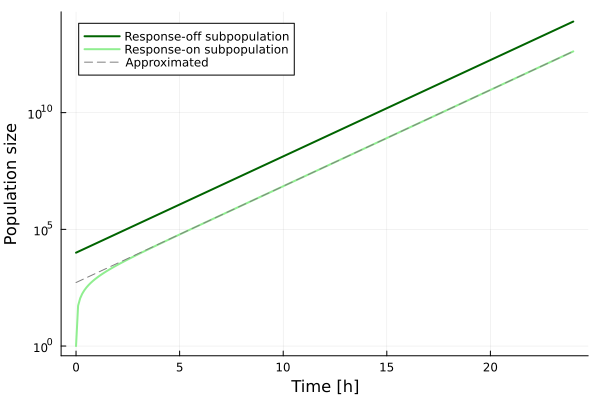

In [97]:
function default_paras()
    global N0_off = 10^4
    global gamma_off = 1.
    global delta_off = 0.
    global switching = 0.05
    global N0_on = 1.
    global gamma_on_rel = 0.
    global delta_on = 0.
    global tf = 24
end
default_paras()
P_popdyn = plot(xlab="Time [h]", ylab="Population size", yscale=:log10, legend=:topleft)
plot!(0:0.1:tf, x -> pop_size_exp(x, N0_off, gamma_off-delta_off-switching), lab="Response-off subpopulation", c=:darkgreen, width=2)
plot!(0:0.1:tf, x -> pop_size_exp(x, N0_off, gamma_off-delta_off-switching, switching, N0_on, gamma_on_rel*gamma_off-delta_on), lab="Response-on subpopulation", c=:lightgreen, width=2)
plot!(0:0.1:tf, x -> N0_off*switching/(gamma_off-delta_off-switching - (gamma_on_rel*gamma_off-delta_on)) * exp((gamma_off-delta_off-switching)*x), lab="Approximated", style=:dash, c=:grey)

### How do the population dynamics depend on the antibiotic concentration?

In [98]:
# Population growth rate depending on antibiotic concentration
growth_rate(lambda_max, c, IC50, hill_coeff) = lambda_max/(1+(c/IC50)^hill_coeff)
# Dose-reponse curve from Das et al.
hill_coeff = 4.
C_Das = [0, 3, 4, 5, 6, 8, 10,	12,	16, 19, 24, 30]	
L_Das = [1.7766242417013847, 1.6759786921621884, 1.622073671010411, 1.5935829705158313, 1.4966412849441446, 1.3712351236453877, 1.1687123190092563, 0.8121688962722318, 0.4979127312005524, 0.27448873064044177, 0, 0]
IC50_Das = 12.35
MIC_Das = 19
l = [growth_rate(1., x, IC50_Das, hill_coeff) for x in C_Das]
i, m = linear_fit(l, L_Das)
lambda_max = m

1.6973845718011042

4.907477288111819


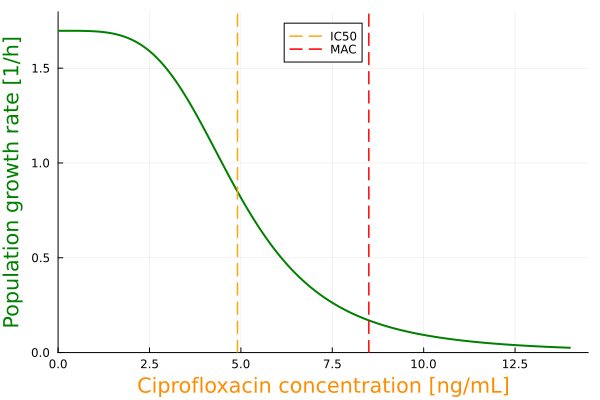

In [99]:
MAC_to_IC50(MAC, hill_coeff) = MAC/9^(1/hill_coeff)
IC50 = MAC_to_IC50(MAC, hill_coeff)
println(IC50)
P_lambda = plot(xlab="Ciprofloxacin concentration [ng/mL]", ylab="Population growth rate [1/h]", legend=:top, xlim=(0,maximum(C)+0.5), ylim=(0,lambda_max+0.1), yguidefont=font(:green), xguidefont=font(:darkorange))
plot!(0:0.1:maximum(C), x -> growth_rate(lambda_max, x, IC50, hill_coeff), lab="", c=:green, width=2)
vline!([IC50], lab="IC50", style=:dash, c=:orange, width=1.5)
vline!([MAC], lab="MAC", style=:dash, c=:red, width=1.5)

0.015999999999999986


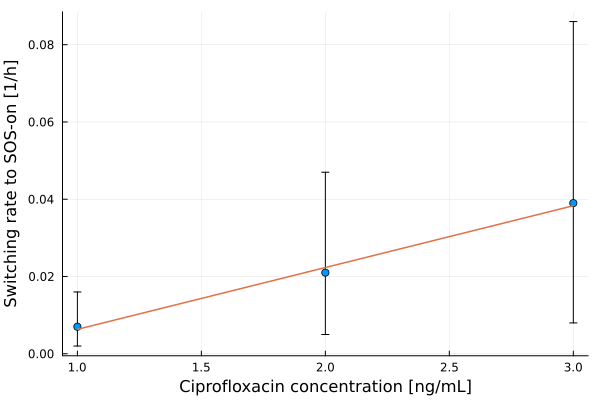

In [100]:
# Switching rate increases with division rate and with antibiotic concentration
switching_rate(gamma_off, c, scaling_factor) = scaling_factor*gamma_off*c
# Estimated switching rate for different ciprofloxacin concentrations from Jaramillo-Riveri et al.
alpha_mean = [0.007, 0.021, 0.039]
alpha_sme = [0.002, 0.005, 0.008]
alpha_0, scaling_factor = linear_fit(1:3, alpha_mean)
println(scaling_factor)
P_alpha = plot(ylab="Switching rate to SOS-on [1/h]", xlab="Ciprofloxacin concentration [ng/mL]", legend=:false)
scatter!(1:3, alpha_mean, yerror=(alpha_mean.-alpha_sme, alpha_mean.+alpha_sme), lab="Mother machine data Jaramillo-Riveri et al.")
plot!(1:3, x -> alpha_0 + x*scaling_factor, lab="Linear least squares fit", width=1.5)

### Bacteriostatic: antibiotic action through reduced division but without cell death

In [102]:
# Calculate the population dynamic parameters depending on the concentration for bacteriostatic drug
function pop_dyn_paras(c)
    # Population growth rate -> dose-repsonse curve
    pop_growth = growth_rate(lambda_max, c, IC50, hill_coeff)
    # Decrease in population growth rate due to change in division rate off-cells and switching rate
    gamma_off = pop_growth/(1 - c*scaling_factor)
    switching = switching_rate(gamma_off, c, scaling_factor)
    # Optionally, change in division rate on-cells (rel. division rate is fixed)
    gamma_on = gamma_off*gamma_on_rel
    return pop_growth, switching, gamma_on
end
function pop_sizes_exp(t, c)
    pop_growth, switching, gamma_on = pop_dyn_paras(c)
    n_on = pop_size_exp(t, N0_off, pop_growth, switching, N0_on, gamma_on-delta_on)
    n_off = pop_size_exp(t, N0_off, pop_growth)
    return n_on, n_off
end
function fraction_on_exp(t, c)
    n_on, n_off = pop_sizes_exp(t, c)
    return n_on / (n_on + n_off)
end
function fraction_on_stat(c)
    pop_growth, switching, gamma_on = pop_dyn_paras(c)
    if gamma_on - delta_on < pop_growth
        return switching/(pop_growth + switching - (gamma_on-delta_on))
    else
        return 1
    end
end

fraction_on_stat (generic function with 2 methods)

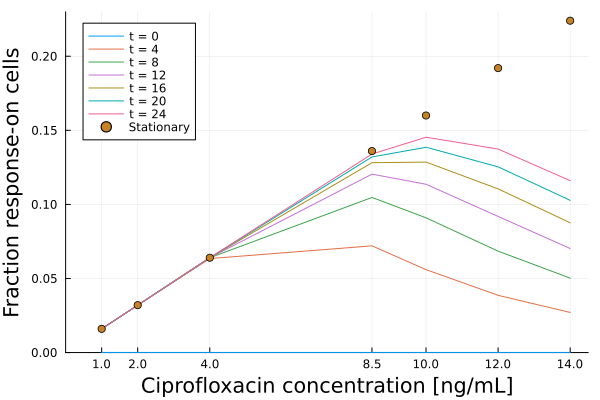

In [103]:
default_paras()
P_f1 = plot(xlab="Ciprofloxacin concentration [ng/mL]", ylab="Fraction response-on cells", ylim=(0., 0.23), xlim=(0,maximum(C)+0.5), xticks=([1,2,4,8.5,10,12,14]), xguidefontsize=14, yguidefontsize=14)
for y in 0:4:24
    plot!(C, x -> fraction_on_exp(y, x), lab="t = $y")
end
scatter!(C, x -> fraction_on_stat(x), lab="Stationary")

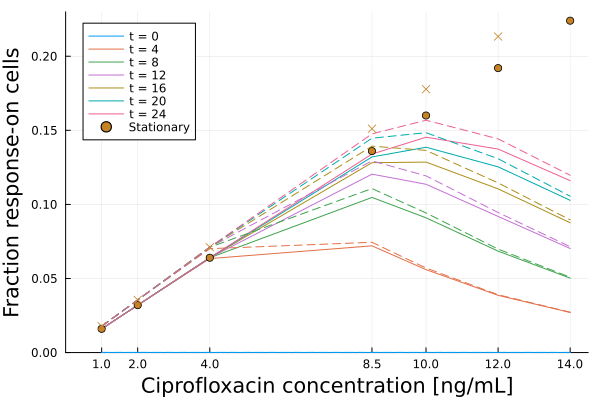

In [104]:
gamma_on_rel = 0.1
P_f1_r = plot(P_f1)
i = 1
for y in 0:4:24
    plot!(C, x -> fraction_on_exp(y, x), lab="", c=palette(:default)[i], style=:dash)
    i += 1
end
scatter!(C, x -> fraction_on_stat(x), lab="", c=palette(:default)[i], marker=:x)

In [105]:
default_paras()
function dfraction_on_stat(delta_on)
    dfon(c) = IC50*scaling_factor*lambda_max * (delta_on*(1 - 3*(c/IC50)^4 + 4*IC50*scaling_factor*(c/IC50)^5) + lambda_max*(1-gamma_on_rel)) / ((1+(c/IC50)^4)*delta_on*(1-scaling_factor*c) + lambda_max*(1-gamma_on_rel))^2
    c = maximum(C)
    try
        c = find_zero(dfon, (0., maximum(C)))
    catch
    end
    return c
end
function c_max_M(P)
    if P[1] < 0. 
        return Inf
    else
        return abs(dfraction_on_stat(P[1]) - MAC)
    end
end
res = Optim.optimize(c_max_M, [0.])
delta_on = Optim.minimizer(res)[1]

0.08042952120304107

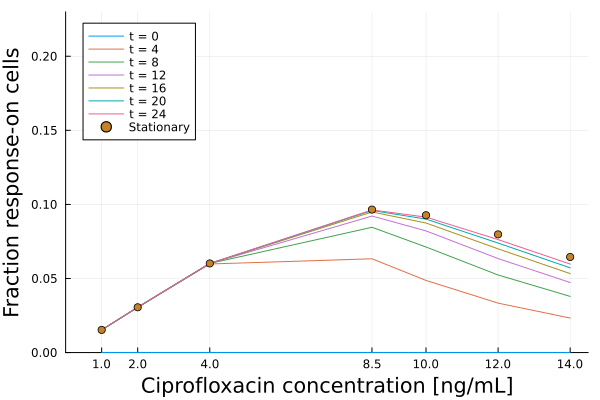

In [106]:
P_f2 = plot(xlab="Ciprofloxacin concentration [ng/mL]", ylab="Fraction response-on cells", ylim=(0., 0.23), xlim=(0,maximum(C)+0.5), xticks=([1,2,4,8.5,10,12,14]), legend=:topleft, xguidefontsize=14, yguidefontsize=14)
for y in 0:4:24
    plot!(C, x -> fraction_on_exp(y, x), lab="t = $y")
end
scatter!(C, x -> fraction_on_stat(x), lab="Stationary")

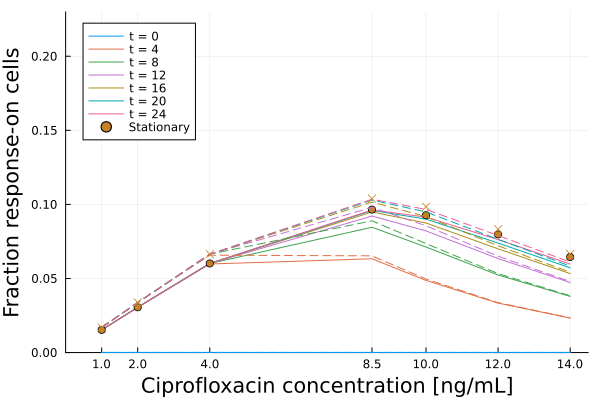

In [107]:
gamma_on_rel = 0.1
P_f2_r = plot(P_f2)
i = 1
for y in 0:4:24
    plot!(C, x -> fraction_on_exp(y, x), lab="", c=palette(:default)[i], style=:dash)
    i += 1
end
scatter!(C, x -> fraction_on_stat(x), lab="", c=palette(:default)[i], marker=:x)

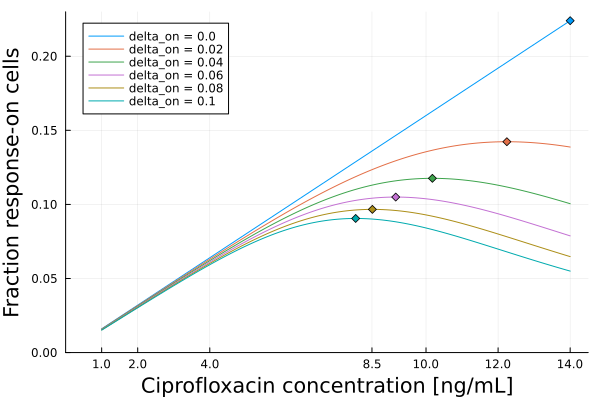

In [108]:
default_paras()
P_f = plot(xlab="Ciprofloxacin concentration [ng/mL]", ylab="Fraction response-on cells", ylim=(0., 0.23), xlim=(0,maximum(C)+0.5), xticks=([1,2,4,8.5,10,12,14]), legend=:topleft, xguidefontsize=14, yguidefontsize=14)
i = 1
for y in 0:0.02:0.1
    delta_on = y
    plot!(1:0.1:maximum(C), x -> fraction_on_stat(x), lab="delta_on = $y", c=palette(:default)[i])
    c = dfraction_on_stat(y)[1]
    scatter!([c], [fraction_on_stat(c)], lab="", c=palette(:default)[i], marker=:d)
    i += 1
end
P_f

### Bacteriostatic: antibiotic action through increased death rate

In [109]:
# Calculate the population dynamic parameters depending on the concentration for bacteriostatic drug
function pop_dyn_paras(c, death)
    # Population growth rate -> dose-repsonse curve
    pop_growth = growth_rate(lambda_max, c, IC50, hill_coeff)
    # Change in population growth rate due to cell death -> division rate off-cells is constant
    switching = switching_rate(gamma_off, c, scaling_factor)
    # On-cells have same death rate as off-cells
    delta_on_new = delta_on + gamma_off - switching - pop_growth
    return pop_growth, switching, delta_on_new
end
function pop_sizes_exp(t, c, death)
    pop_growth, switching, delta_on_new = pop_dyn_paras(c, death)
    n_off = pop_size_exp(t, N0_off, pop_growth)
    if death == true
        n_on = pop_size_exp(t, N0_off, pop_growth, switching, N0_on, gamma_off*gamma_on_rel-delta_on_new)
    else
        n_on = pop_size_exp(t, N0_off, pop_growth, switching, N0_on, gamma_off*gamma_on_rel-delta_on)
    end
    return n_on, n_off
end
function fraction_on_exp(t, c, death)
    n_on, n_off = pop_sizes_exp(t, c, death)
    return n_on / (n_on + n_off)
end
function fraction_on_stat(c, death)
    pop_growth, switching, delta_on_new = pop_dyn_paras(c, death)
    if death == true
        if gamma_off*gamma_on_rel-delta_on_new < pop_growth
            return switching/(pop_growth + switching - (gamma_off*gamma_on_rel-delta_on_new))
        else
            return 1
        end
    else
        if gamma_off*gamma_on_rel-delta_on < pop_growth
            return switching/(pop_growth + switching - (gamma_off*gamma_on_rel-delta_on))
        else
            return 1
        end
    end
end

fraction_on_stat (generic function with 2 methods)

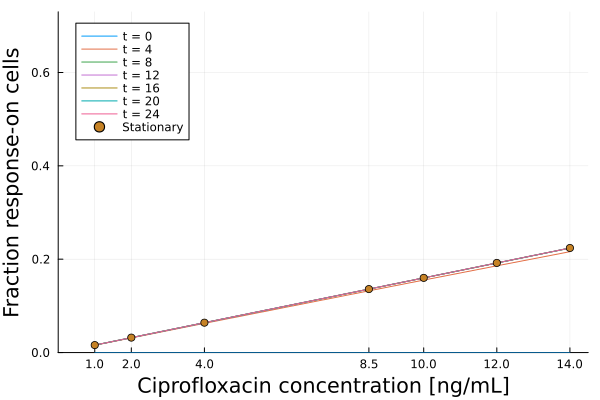

In [110]:
default_paras()
P_f_d1 = plot(xlab="Ciprofloxacin concentration [ng/mL]", ylab="Fraction response-on cells", ylim=(0., 0.73), xlim=(0,maximum(C)+0.5), xticks=([1,2,4,8.5,10,12,14]), legend=:topleft, xguidefontsize=14, yguidefontsize=14)
for y in 0:4:24
    plot!(C, x -> fraction_on_exp(y, x, true), lab="t = $y")
end
scatter!(C, x -> fraction_on_stat(x, true), lab="Stationary")

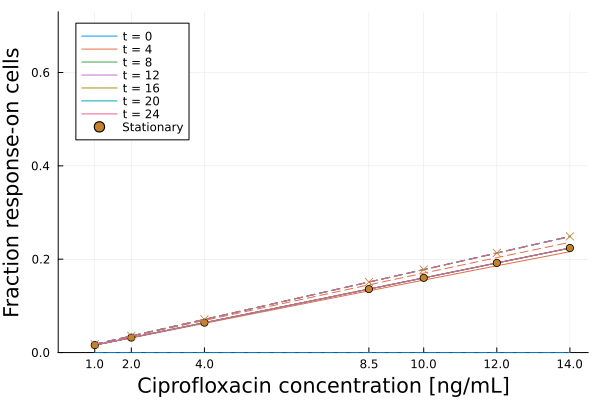

In [111]:
gamma_on_rel = 0.1
P_f_d1_r = plot(P_f_d1)
i = 1
for y in 0:4:24
    plot!(C, x -> fraction_on_exp(y, x, true), lab="", c=palette(:default)[i], style=:dash)
    i += 1
end
scatter!(C, x -> fraction_on_stat(x, true), lab="", c=palette(:default)[i], marker=:x)

In [112]:
default_paras()
function dfraction_on_cidal(delta_on)
    dfon(c) = -IC50*scaling_factor*lambda_max*((1 + (c/IC50)^4)^2 * (delta_on-gamma_on_rel*lambda_max) + lambda_max*(1 + 5*(c/IC50)^4)) / ((1 + (c/IC50)^4) * (delta_on - lambda_max*(c*scaling_factor-gamma_on_rel)) + lambda_max)^2
    c = maximum(C)
    try
        res = Optim.optimize(dfon, 0., maximum(C))
        c = Optim.minimizer(res)[1]
    catch
    end
    return c
end
function c_max_dM(P)
    if P[1] < 0. 
        return Inf
    else
        return abs(dfraction_on_cidal(P[1])[1] - MAC)
    end
end
res = Optim.optimize(c_max_dM, [0.])
delta_on = Optim.minimizer(res)[1]

0.06110584139823916

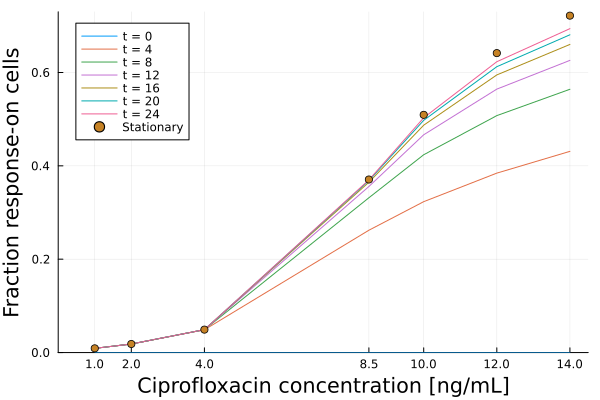

In [113]:
P_f_d2 = plot(xlab="Ciprofloxacin concentration [ng/mL]", ylab="Fraction response-on cells", ylim=(0., 0.73), xlim=(0,maximum(C)+0.5), xticks=([1,2,4,8.5,10,12,14]), xguidefontsize=14, yguidefontsize=14)
for y in 0:4:24
    plot!(C, x -> fraction_on_exp(y, x, false), lab="t = $y")
end
scatter!(C, x -> fraction_on_stat(x, false), lab="Stationary")

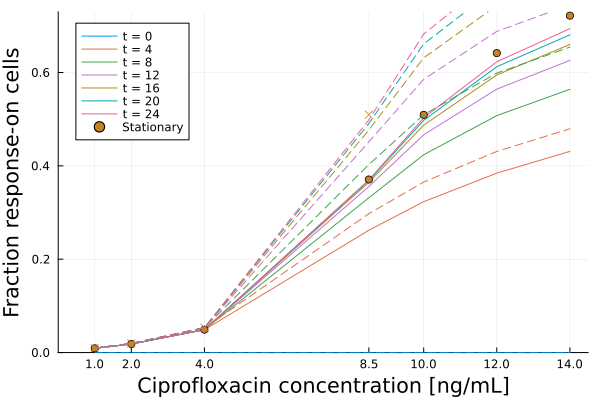

In [114]:
gamma_on_rel = 0.1
P_f_d2_r = plot(P_f_d2)
i = 1
for y in 0:4:24
    plot!(C, x -> fraction_on_exp(y, x, false), lab="", c=palette(:default)[i], style=:dash)
    i += 1
end
scatter!(C, x -> fraction_on_stat(x, false), lab="", c=palette(:default)[i], marker=:x)

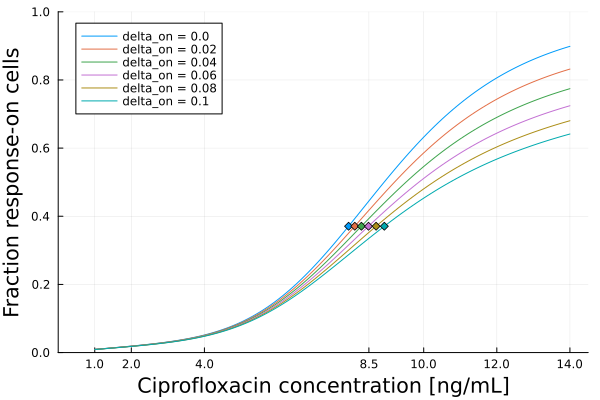

In [115]:
default_paras()
P_f_d = plot(xlab="Ciprofloxacin concentration [ng/mL]", ylab="Fraction response-on cells", ylim=(0., 1.), xlim=(0,maximum(C)+0.5), xticks=([1,2,4,8.5,10,12,14]), xguidefontsize=14, yguidefontsize=14)
i = 1
for y in 0:0.02:0.1
    delta_on = y
    plot!(1:0.1:maximum(C), x -> fraction_on_stat(x, false), lab="delta_on = $y", c=palette(:default)[i])
    c = dfraction_on_cidal(y)[1]
    scatter!([c], [fraction_on_stat(c, false)], lab="", c=palette(:default)[i], marker=:d)
    i += 1
end
P_f_d

In [149]:
function fit_M()
    F = [fraction_on_exp(tf, x) for x in C]
    df = DataFrame(X = F[1:3], Y = M_MLE[1:3])
    res = lm(@formula(Y ~ X + 0), df)
    m_stat_0 = coef(res)[1]
    global M_stat_0 = F .* m_stat_0
    println(("Bacteriostatic, delta_on = 0: ", m_stat_0-1, "SSR = ", sum((M_stat_0 .* M_MLE).^2)))
    println(coef(res) ./ stderror(res))
    F = [fraction_on_exp(tf, x, false) for x in C]
    df = DataFrame(X = F[1:3], Y = M_MLE[1:3])
    res = lm(@formula(Y ~ X + 0), df)
    m_cidal_0 = coef(res)[1]
    global M_cidal_0 = F .* m_cidal_0
    println(("Bacteriocidal, delta_on = 0: ", m_cidal_0-1, "SSR = ", sum((M_cidal_0 .* M_MLE).^2)))
    println(coef(res) ./ stderror(res))
    res = Optim.optimize(c_max_M, [0.])
    delta_on = Optim.minimizer(res)[1]
    F = [fraction_on_exp(tf, x) for x in C]
    df = DataFrame(X = F[1:3], Y = M_MLE[1:3])
    res = lm(@formula(Y ~ X + 0), df)
    m_stat_opt = coef(res)[1]
    global M_stat_opt = F .* m_stat_opt
    println(("Bacteriostatic, delta_on = $delta_on", m_stat_opt-1, "SSR = ", sum((M_stat_opt .* M_MLE).^2)))
    println(coef(res) ./ stderror(res))
    res = Optim.optimize(c_max_dM, [0.])
    delta_on = Optim.minimizer(res)[1]
    F = [fraction_on_exp(tf, x, false) for x in C]
    df = DataFrame(X = F[1:3], Y = M_MLE[1:3])
    res = lm(@formula(Y ~ X + 0), df)
    m_cidal_opt = coef(res)[1]
    global M_cidal_opt = F .* m_cidal_opt
    println(("Bacteriocidal, delta_on = $delta_on", m_cidal_opt-1, "SSR = ", sum((M_cidal_opt .* M_MLE).^2)))
    println(coef(res) ./ stderror(res))
    F = [fraction_on_exp(tf, x, true) for x in C]
    df = DataFrame(X = F[1:3], Y = M_MLE[1:3])
    res = lm(@formula(Y ~ X + 0), df)
    m_cidal_1 = coef(res)[1]
    global M_cidal_1 = F .* m_cidal_1
    println(("Bacteriocidal, delta_on = delta_off ", m_cidal_1-1, "SSR = ", sum((M_cidal_1 .* M_MLE).^2)))
    println(coef(res) ./ stderror(res))
end

fit_M (generic function with 1 method)

In [150]:
default_paras()
gamma_on_rel = 0.1
fit_M()

("Bacteriostatic, delta_on = 0: ", 66.76785714338084, "SSR = ", 140509.1338370591)
[14.510545167359956]
("Bacteriocidal, delta_on = 0: ", 89.53548585360862, "SSR = ", 5.749278291840283e6)
[8.369081257127228]
("Bacteriostatic, delta_on = 0.07238656738772989", 66.76785714338084, "SSR = ", 140509.1338370591)
[14.510545167359956]
("Bacteriocidal, delta_on = 1.1175870895385744e-9", 89.53548585360862, "SSR = ", 5.749278291840283e6)
[8.369081257127228]
("Bacteriocidal, delta_on = delta_off ", 66.76785724906736, "SSR = ", 186790.0548205906)
[14.510545179664215]


In [151]:
default_paras()
fit_M()

("Bacteriostatic, delta_on = 0: ", 74.29761904764774, "SSR = ", 146348.79616698693)
[14.510545167315334]
("Bacteriocidal, delta_on = 0: ", 97.25096704911343, "SSR = ", 3.8785357966011693e6)
[8.708930422103245]
("Bacteriostatic, delta_on = 0.08042952120304107", 74.29761904764774, "SSR = ", 146348.79616698693)
[14.510545167315334]
("Bacteriocidal, delta_on = 0.06110584139823916", 97.25096704911343, "SSR = ", 3.8785357966011693e6)
[8.708930422103245]
("Bacteriocidal, delta_on = delta_off ", 74.29761905839935, "SSR = ", 186790.06160114796)
[14.510545168443983]


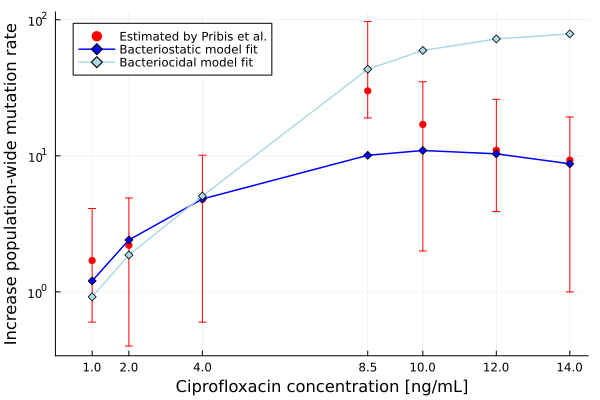

In [124]:
P_M_fit = plot(P_M)
plot!(P_M_fit, C, M_stat_opt, lab="Bacteriostatic model fit", marker=:d, c=:blue, width=1.5)
plot!(C, M_cidal_opt, lab="Bacteriocidal model fit", marker=:d, c=:lightblue, width=1.5)

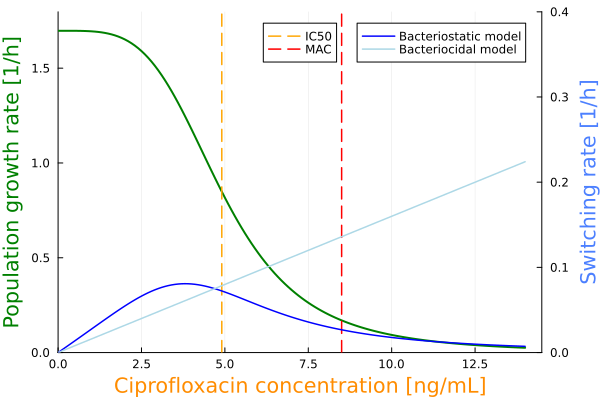

In [128]:
default_paras()
alpha_stat = [pop_dyn_paras(x)[2] for x in 0:0.1:maximum(C)]
alpha_cidal = [pop_dyn_paras(x, true)[2] for x in 0:0.1:maximum(C)]
plot(P_lambda)
plot!(twinx(), 0:0.1:maximum(C), [alpha_stat alpha_cidal], lab=["Bacteriostatic model" "Bacteriocidal model"], c=[:blue :lightblue], ylab="Switching rate [1/h]", ylim=(0,0.4), width=1.5, legend=:topright, xlim=(0,maximum(C)+0.5), yguidefont=font(RGB(0.3,0.5,1)))

## 2. Logistic growth (exponential + stationary phase)

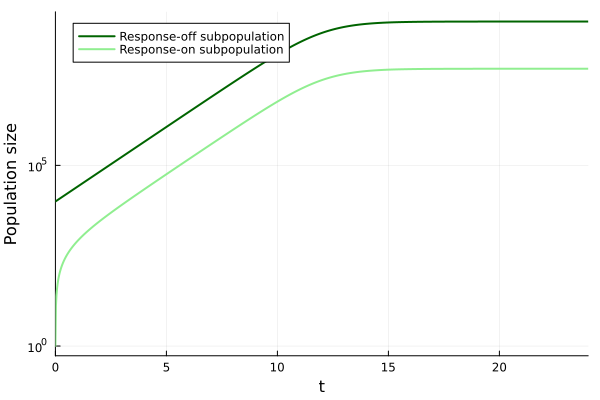

In [26]:
Nf = 10^9
function pop_sizes_log(du, u, p, t)
    n1, n2 = u
    Nf, pop_growth, switching, net_growth_on = p
    du[1] = dn1 = pop_growth * (1 - (n1+n2)/Nf)*n1
    du[2] = dn2 = net_growth_on * (1 - (n1+n2)/Nf)*n2 + switching * (1 - (n1+n2)/Nf)*n1
end
pop_growth = gamma_off - delta_off - switching
net_growth_on = gamma_on_rel*gamma_off - delta_on
n01, n02 = N0_off, N0_on
u0 = [n01, n02]
tspan = (0., tf)
p = [Nf, pop_growth, switching, net_growth_on]
prob = ODEProblem(pop_sizes_log, u0, tspan, p)
sol = solve(prob)
P_popdyn_stat = plot(xlab="Time [h]", ylab="Population size", yscale=:log10, legend=:topleft)
plot!(sol, lab=["Response-off subpopulation" "Response-on subpopulation"], c=[:darkgreen :lightgreen], width=2)